# PIC-SURE API use-case: PheWAS analyzes on CSC data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pprint import pprint

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats

import PicSureHpdsLib
import PicSureClient

from python_lib.tokenManager import tokenManager
from python_lib.utils import get_multiIndex_variablesTable, get_dic_renaming_vars, match_dummies_to_varNames, joining_variablesTable_onCol

In [3]:
# Matplotlib parameters options
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
fig_size[0] = 14
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

font = {'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

In [4]:
pd.set_option("max.rows", 150)

## Connection to HPDS resources

In [5]:
with open("./dic_resources.json") as f:
    platforms_credentials = json.load(f)

In [6]:
credentials = platforms_credentials["csc"]

In [7]:
pprint(credentials)

{'resource': '37663534-6161-3830-6264-323031316539',
 'token_file': './tokens/csc.txt',
 'url': 'https://curesc.hms.harvard.edu/picsure/'}


In [11]:
token_manager = tokenManager(credentials["token_file"])
__token__ = token_manager.importToken(paste_from_clipboard=True)

Token pasted from clipboard

[_Security_Token_Imported_Correctly_]


In [12]:
client = PicSureClient.Client()
connection = client.connect(credentials["url"], __token__, allowSelfSignedSSL=True)
adapter = PicSureHpdsLib.Adapter(connection)
resource = adapter.useResource(credentials["resource"])
connection.list()

+--------------------------------------+------------------------------------------------------
|  Resource UUID                       |  Resource Name                                  
+--------------------------------------+------------------------------------------------------
| 37663534-6161-3830-6264-323031316539 | hpds
| Description: hpds
+--------------------------------------+------------------------------------------------------
| fd4c0264-b9f3-11e9-ae54-0aae033be7c2 | IRCT
| Description: IRCT Resource
+--------------------------------------+------------------------------------------------------


## Retrieving dictionnary from an HPDS resource

The `resource.dictionary` object offers the possibility to retrieve matching records according to a specific term, or to retrieve informations about all variables using the `find()` method. 

In [15]:
dic_query = resource.dictionary().find("Sex")

Subsequently, `find` expose the result using 4 different methods: `.count()`, `.keys()`, `.entries`, and `.DataFrame()`.

In [16]:
pprint({"Count": dic_query.count(), 
        "Keys": dic_query.keys(),
        "Entries": dic_query.entries()})

{'Count': 1,
 'Entries': [{'HpdsDataType': 'phenotypes',
              'categorical': True,
              'categoryValues': ['Female', 'Male'],
              'name': '\\MCW - Cure Sickle Cell Disease\\1 - Patient '
                      'Related\\1 - Demographics\\Sex\\',
              'observationCount': 1247,
              'patientCount': 0}],
 'Keys': ['\\MCW - Cure Sickle Cell Disease\\1 - Patient Related\\1 - '
          'Demographics\\Sex\\']}


In [17]:
dic_query.DataFrame()

,categoryValues,categorical,observationCount,patientCount,HpdsDataType
KEY,,,,,
\MCW - Cure Sickle Cell Disease\1 - Patient Related\1 - Demographics\Sex\,"[Female, Male]",True,1247,0,phenotypes


**`.DataFrame()` appears as the most useful method for an end-user**. May even be the cornerstone of the analysis, because

* Various criteria reported in the dictionary (patientCount, variable type ...) can be used as selection criteria for pheotype selection.
* Row names of the DataFrame, representing actual variables names, can be used in the query, instead of typing directly the name of the variable in the source code. Alternatively, variable names can be obtained from using the `find.keys()`. 

Very important to expose handy methods to get variable names, because end-user won't type the variable names.
1. Too long
2. Presence of backslashes that prevent from copy-pasting. 


In [22]:
query = resource.query()
query.require().add("\\MCW - Cure Sickle Cell Disease\\1 - Patient Related\\1 - Demographics\\Sex\\")
query.getCount()

1247

In [23]:
simple_variablesTable = resource.dictionary().find().DataFrame()

In [25]:
query = resource.query()
gender_variables = resource.dictionary().find("Sex").keys()
query.require().add(gender_variables)
query.getCount()

1247

### Query methods

In [26]:
query.help()


        .select()       list of data fields to return from resource for each record
        .crosscounts()  list of data fields that cross counts will be calculated for
        .require()      list of data fields that must be present in all returned records
        .anyof()        list of data fields that records must be a member of at least one entry
        .filter()       list of data fields and conditions that returned records satisfy
                  [ Filter keys exert an AND relationship on returned records      ]
                  [ Categorical values have an OR relationship on their key        ]
                  [ Numerical Ranges are inclusive of their start and end points   ]

        .getCount()             single count indicating the number of matching records
        .getCrossCount()        array indicating number of matching records per cross-count keys
        .getResults()           CSV-like string containing the matching records
        .getResultsDataFrame()  pand

#### Selecting variables

`query.select()` is in my opinion the most useful method among the ones provided, and may be the only one used if combined with dictionary. My workflow has been to look for the informations in the dictionary rendered as a DataFrame, and creating a filter based on information provided by the dictionary.

Created wrappers to add a "MultiIndex" and 2 columns varName and simplified_varName. Useful to explore "by hand" the variables according to their names.

In [27]:
variablesTable = get_multiIndex_variablesTable(simple_variablesTable)

In [28]:
variablesTable

varName  \
MCW - Cure Sickle Cell Disease 1 - Patient Related    1 - Demographics                                   Patient age (cat) at transplant years               \MCW - Cure Sickle Cell Disease\1 - Patient Re...   
                                                                                                         Patient age at transplant years                     \MCW - Cure Sickle Cell Disease\1 - Patient Re...   
                                                                                                         Sex                                                 \MCW - Cure Sickle Cell Disease\1 - Patient Re...   
                                                      2 - Race and Ethnicitiy                            Ethnicity                                           \MCW - Cure Sickle Cell Disease\1 - Patient Re...   
                                                                                                         Race                                                \MCW - Cure Sickle Cell Disease\1 - Patient Re...   
                                                      3 - Publications                                   Cases from 2016 Blood publication                   \MCW - Cure Sickle Cell Disease\1 - Patient Re...   
                                                                                                         Cases from 2019 Lancet Heamatology publication      \MCW - Cure Sickle Cell Disease\1 - Patient Re...   
                                                      CCN                                                NaN                                                 \MCW - Cure Sickle Cell Disease\1 - Patient Re...   
                                                      Country of HCT institution                         NaN                                                 \MCW - Cure Sickle Cell Disease\1 - Patient Re...   
                                                      HCT-comorbidity index                              NaN                                                 \MCW - Cure Sickle Cell Disease\1 - Patient Re...   
                                                      ID                                                 NaN                                                 \MCW - Cure Sickle Cell Disease\1 - Patient Re...   
                                                      KarnofskyLansky score at HCT                       NaN                                                 \MCW - Cure Sickle Cell Disease\1 - Patient Re...   
                               2 - Disease related    Disease genotype                                   NaN                                                 \MCW - Cure Sickle Cell Disease\2 - Disease re...   
                               3 - Transplant related ATGAlemtuzumab given as conditioning regimenGVH... NaN                                                 \MCW - Cure Sickle Cell Disease\3 - Transplant...   
                                                      Conditioning intensity                             NaN                                                 \MCW - Cure Sickle Cell Disease\3 - Transplant...   
                                                      Conditioning regimen                               NaN                                                 \MCW - Cure Sickle Cell Disease\3 - Transplant...   
                                                      Donor type                                         NaN                                                 \MCW - Cure Sickle Cell Disease\3 - Transplant...   
                                                      Donor-recipient HLA matching                       NaN                                                 \MCW - Cure Sickle Cell Disease\3 - Transplant...   
                                                      GVHD prophylaxis                                   NaN                                                 \MCW - Cure Sickle Cell Disease\3 - Transplant...   

## Retrieving data from HPDS

Let's filter on the number of entities available for each variable, because right now require() only allows us to retrieve non empty fields. 

### Criteria to select variables

As of 11/22, `query().select()` doesn't work on CSC database, we must use `query.require()`, which is equivalent of selecting records for variables which contain non-null values.

In [29]:
threshold = 1000
mask_vars = variablesTable["observationCount"] >= threshold
selected_vars = variablesTable.loc[mask_vars, "varName"].to_list()
pprint("Variable names selected: \n {0}".format(selected_vars[:5]))
pprint("[...] \n {0}".format(selected_vars[-5:]))

('Variable names selected: \n'
 " ['\\\\MCW - Cure Sickle Cell Disease\\\\1 - Patient Related\\\\1 - "
 "Demographics\\\\Patient age (cat) at transplant years\\\\', '\\\\MCW - Cure "
 'Sickle Cell Disease\\\\1 - Patient Related\\\\1 - Demographics\\\\Patient '
 "age at transplant years\\\\', '\\\\MCW - Cure Sickle Cell Disease\\\\1 - "
 "Patient Related\\\\1 - Demographics\\\\Sex\\\\', '\\\\MCW - Cure Sickle Cell "
 "Disease\\\\1 - Patient Related\\\\2 - Race and Ethnicitiy\\\\Ethnicity\\\\', "
 "'\\\\MCW - Cure Sickle Cell Disease\\\\1 - Patient Related\\\\2 - Race and "
 "Ethnicitiy\\\\Race\\\\']")
('[...] \n'
 " ['\\\\MCW - Cure Sickle Cell Disease\\\\4 - Outcomes\\\\Z - Other "
 "outcomes\\\\Acute chest syndrome post HCT\\\\', '\\\\MCW - Cure Sickle Cell "
 "Disease\\\\4 - Outcomes\\\\Z - Other outcomes\\\\Stroke post HCT\\\\', "
 "'\\\\MCW - Cure Sickle Cell Disease\\\\4 - Outcomes\\\\Z - Other "
 "outcomes\\\\Vaso-occlusive pain post HCT\\\\', '\\\\MCW - Cure Sickle Cell "
 "Dise

### Implementing the query

In [34]:
query = resource.query()
query.select().add(selected_vars)

In [ ]:
count = query.getCount()

In [ ]:
facts = query.getResultsDataFrame(selected_vars).set_index("Patient ID")
nb_vars = facts.shape[1]

Update 11/25: query methods don't work anymore on CSC dataset.

As an alternative to `getCount()/crossCount()`, an overview of the query before it runs might be interesting, something as the following.

In [123]:
nb_phenotypes = np.where(variablesTable.loc[mask_vars,"HpdsDataType"] == "phenotypes", 1, 0).sum()
nb_genotypes = np.where(variablesTable.loc[mask_vars,"HpdsDataType"] == "genotypes", 1, 0).sum()

In [124]:
print("Query will return a DataFrame with {0} vars and {1} rows".format(nb_vars, count))
print("Number of phenotypes variables: {0}, number of genotypes variables: {1}".format(nb_phenotypes, nb_genotypes))
print("Number of categorical variables: {0}, number of numerical variabes: {1} among phenotypes variables".format("X", "Y"))
print("Number of variables with no values: {0}".format("X"))
print("Observation per variables: mean = {mean}, min = {min}, max = {max}".format(mean="X", min="Y", max="Z"))
print("Proceed?")

Query will return a DataFrame with 275 vars and 10371 rows
Number of phenotypes variables: 275, number of genotypes variables: 0
Number of categorical variables: X, number of numerical variabes: Y among phenotypes variables
Number of variables with no values: X
Observation per variables: mean = X, min = Y, max = Z
Proceed?


## Preparing the data for PheWAS

- Selecting variables regarding their types: key parameter in a PheWAS

In [125]:
mask_categories = variablesTable.loc[mask_vars,"categorical"] == True
categorical_varnames = variablesTable.loc[mask_vars,:].loc[mask_categories, "varName"].unique().tolist()
continuous_varnames = variablesTable.loc[mask_vars,:].loc[~mask_categories, "varName"].unique().tolist()

- Selecting the genetic variant to study

In [126]:
gene_name = variablesTable.loc[variablesTable["simplified_varName"] == "Gender", "varName"].values[0]
categorical_varnames.remove(gene_name)

- Creating dummy variables in order to be able to carry statistical tests

In [127]:
facts_dummies = pd.get_dummies(facts, columns=categorical_varnames, drop_first=True)

In [128]:
matching_dummies_varNames = match_dummies_to_varNames(facts.columns,
                                                      facts_dummies.columns,
                                                      columns=["varName", "dummies_varName"])

* Storing the new dummy variable names into variablesTable DataFrame (dictionary).

In [129]:
variablesTable = joining_variablesTable_onCol(variablesTable,
                                              matching_dummies_varNames,
                                              left_col="varName",
                                              right_col="varName",
                                              overwrite=False)

In [130]:
variablesTable.head(5)

varName  \
level_0             level_1           level_2 level_3 level_4                                        
00 Affection status NaN               NaN     NaN     NaN                    \00 Affection status\   
                                                      NaN                    \00 Affection status\   
                                                      NaN                    \00 Affection status\   
00 Consent groups   NaN               NaN     NaN     NaN                      \00 Consent groups\   
01 Demographics     Age at enrollment NaN     NaN     NaN      \01 Demographics\Age at enrollment\   

                                                                simplified_varName  \
level_0             level_1           level_2 level_3 level_4                        
00 Affection status NaN               NaN     NaN     NaN      00 Affection status   
                                                      NaN      00 Affection status   
                                                      NaN      00 Affection status   
00 Consent groups   NaN               NaN     NaN     NaN        00 Consent groups   
01 Demographics     Age at enrollment NaN     NaN     NaN        Age at enrollment   

                                                               patientCount  \
level_0             level_1           level_2 level_3 level_4                 
00 Affection status NaN               NaN     NaN     NaN                 0   
                                                      NaN                 0   
                                                      NaN                 0   
00 Consent groups   NaN               NaN     NaN     NaN                 0   
01 Demographics     Age at enrollment NaN     NaN     NaN                 0   

                                                                min  \
level_0             level_1           level_2 level_3 level_4         
00 Affection status NaN               NaN     NaN     NaN       NaN   
                                                      NaN       NaN   
                                                      NaN       NaN   
00 Consent groups   NaN               NaN     NaN     NaN       NaN   
01 Demographics     Age at enrollment NaN     NaN     NaN      39.9   

                                                               categorical  \
level_0             level_1           level_2 level_3 level_4                
00 Affection status NaN               NaN     NaN     NaN             True   
                                                      NaN             True   
                                                      NaN             True   
00 Consent groups   NaN               NaN     NaN     NaN             True   
01 Demographics     Age at enrollment NaN     NaN     NaN            False   

                                                               observationCount  \
level_0             level_1           level_2 level_3 level_4                     
00 Affection status NaN               NaN     NaN     NaN                 10371   
                                                      NaN                 10371   
                                                      NaN                 10371   
00 Consent groups   NaN               NaN     NaN     NaN                 10371   
01 Demographics     Age at enrollment NaN     NaN     NaN                 10371   

                                                                max  \
level_0             level_1           level_2 level_3 level_4         
00 Affection status NaN               NaN     NaN     NaN       NaN   
                                                      NaN       NaN   
                                                      NaN       NaN   
00 Consent groups   NaN               NaN     NaN     NaN       NaN   
01 Demographics     Age at enrollment NaN     NaN     NaN      85.0   

                                                              HpdsDataType  \
level_0         

## Univariate statistical tests

1. Running an appropriate univariate statistical test according to the type of tested variables, checking for a correlation between studied covariate, and studied allele/traits.
2. Merging those results with variableTables DataFrame

### Quantitative variables test

In [131]:
grouped = results_dummies.groupby(gene_name) # gene_name = "Sex"

# T-test for continuous variables
dic_ttest = {}
for var in continuous_varnames: 
    group1, group2 = [group[1].dropna() for group in grouped[var]]
    dic_ttest[var] = stats.ttest_ind(group1, group2).pvalue

In [147]:
dic_ttest

{'\\01 Demographics\\Age at enrollment\\': 0.7615120944027429,
 '\\01 Demographics\\Other\\Year of visit, to use for longitudinal analysis\\': 0.7505783478157821,
 '\\03 Clinical data\\6-Minute walk test form\\Distance walked in feet\\': 6.549194612160076e-26,
 '\\03 Clinical data\\6-Minute walk test form\\Supplemental O2 used during 6 min walk in L per min\\': 0.2740177496938562,
 '\\03 Clinical data\\CT scan\\CT measurements\\CT Slicer\\Exp Mean Atten Insp Mean Atten ratio CT Slicer\\': 5.830793766495805e-05,
 '\\03 Clinical data\\CT scan\\CT measurements\\CT Slicer\\FRC CT Slicer\\': 0.0,
 '\\03 Clinical data\\CT scan\\CT measurements\\CT Slicer\\HU 15th percentile Exp Total lung CT Slicer\\': 7.058253997830582e-38,
 '\\03 Clinical data\\CT scan\\CT measurements\\CT Slicer\\Hu 15th percentile Insp CT Slicer\\': 1.9136778535415203e-59,
 '\\03 Clinical data\\CT scan\\CT measurements\\CT Slicer\\Intensity Mean Exp Total lung CT Slicer\\': 1.1181396409356768e-19,
 '\\03 Clinical data\\C

In [139]:
pprint([(k, v) for k, v in dic_ttest.items()][:5])

[('\\01 Demographics\\Age at enrollment\\', 0.7615120944027429),
 ('\\01 Demographics\\Other\\Year of visit, to use for longitudinal analysis\\',
  0.7505783478157821),
 ('\\03 Clinical data\\6-Minute walk test form\\Distance walked in feet\\',
  6.549194612160076e-26),
 ('\\03 Clinical data\\6-Minute walk test form\\Supplemental O2 used during 6 '
  'min walk in L per min\\',
  0.2740177496938562),
 ('\\03 Clinical data\\CT scan\\CT measurements\\CT Slicer\\Exp Mean Atten '
  'Insp Mean Atten ratio CT Slicer\\',
  5.830793766495805e-05)]


### Qualitative variables test

In [140]:
dummy_categorical_varnames = variablesTable.loc[variablesTable["varName"].isin(categorical_varnames),:]\
["dummies_varName"].values[:500]

In [143]:
# Fisher test for categorical variables
from tqdm import tqdm
dic_fisher = {}
try:
    for var in tqdm(dummy_categorical_varnames, position=0, leave=True):
        if type(var) != str:
            print("skipping {0}".format(var))
            continue
        elif var not in results_dummies.columns:
            print("skipping {0}, not in dataframe columns".format(var))
            continue        
        crosstab = pd.crosstab(results_dummies[var], results_dummies[gene_name])
        if crosstab.shape == (1,2):
            dic_fisher[var] = np.NaN
        else:
            dic_fisher[var] = stats.fisher_exact(crosstab)[1]
except AttributeError:
    print("End of loop tqdm AttributeError catched")

 11%|█▏        | 27/239 [00:05<01:00,  3.49it/s]

skipping nan


 23%|██▎       | 54/239 [00:13<00:45,  4.07it/s]

skipping nan


100%|██████████| 239/239 [01:07<00:00,  3.54it/s]


## Results visualization

#### Distribution of the univariate tests

Text(0.5, 0.98, 'Distribution of p-values from univariate association tests for quantitative traits')

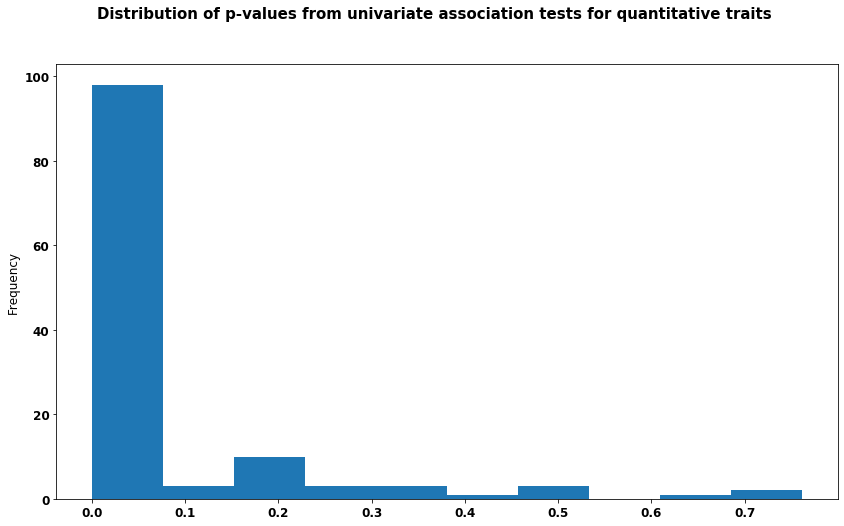

In [153]:
pd.Series([v for v in dic_ttest.values()]).plot.hist(bins=10)
plt.suptitle("Distribution of p-values from univariate association tests for quantitative traits", size="15", weight="bold")

Text(0.5, 0.98, 'Distribution of p-values from univariate association tests for qualitative traits')

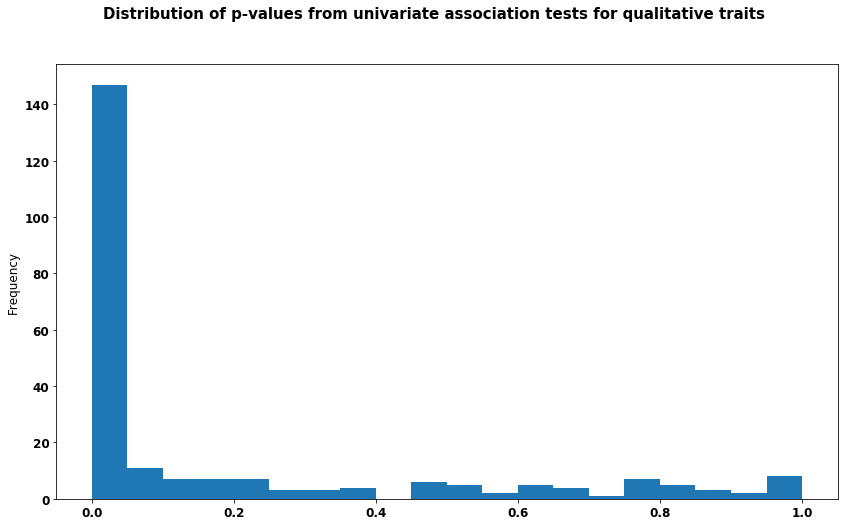

In [154]:
pd.Series([v for v in dic_fisher.values()]).plot.hist(bins=20)
plt.suptitle("Distribution of p-values from univariate association tests for qualitative traits", size=15, weight="bold")

### Manatthan plot

In [155]:
# Merging pvalues from different tests
dic_pvalues = {**dic_ttest, **dic_fisher}
df_pvalues = pd.DataFrame.from_dict(dic_pvalues, orient="index", columns=["pvalues"])\
.rename_axis("dummies_varName")\
.reset_index(drop=False)

In [157]:
# Adding pvalues results to variablesTable
variablesTable = joining_variablesTable_onCol(variablesTable,
                                              df_pvalues,
                                              left_col="dummies_varName",
                                              right_col="dummies_varName")

In [160]:
variablesTable.head()

dummies_varName  \
level_0             level_1           level_2 level_3 level_4                                               
00 Affection status NaN               NaN     NaN     NaN                   \00 Affection status\_Control   
                                                      NaN      \00 Affection status\_Exclusionary Disease   
                                                      NaN                     \00 Affection status\_Other   
00 Consent groups   NaN               NaN     NaN     NaN                    \00 Consent groups\_COPD_HMB   
01 Demographics     Age at enrollment NaN     NaN     NaN             \01 Demographics\Age at enrollment\   

                                                                                           varName  \
level_0             level_1           level_2 level_3 level_4                                        
00 Affection status NaN               NaN     NaN     NaN                    \00 Affection status\   
                                                      NaN                    \00 Affection status\   
                                                      NaN                    \00 Affection status\   
00 Consent groups   NaN               NaN     NaN     NaN                      \00 Consent groups\   
01 Demographics     Age at enrollment NaN     NaN     NaN      \01 Demographics\Age at enrollment\   

                                                                simplified_varName  \
level_0             level_1           level_2 level_3 level_4                        
00 Affection status NaN               NaN     NaN     NaN      00 Affection status   
                                                      NaN      00 Affection status   
                                                      NaN      00 Affection status   
00 Consent groups   NaN               NaN     NaN     NaN        00 Consent groups   
01 Demographics     Age at enrollment NaN     NaN     NaN        Age at enrollment   

                                                               patientCount  \
level_0             level_1           level_2 level_3 level_4                 
00 Affection status NaN               NaN     NaN     NaN                 0   
                                                      NaN                 0   
                                                      NaN                 0   
00 Consent groups   NaN               NaN     NaN     NaN                 0   
01 Demographics     Age at enrollment NaN     NaN     NaN                 0   

                                                                min  \
level_0             level_1           level_2 level_3 level_4         
00 Affection status NaN               NaN     NaN     NaN       NaN   
                                                      NaN       NaN   
                                                      NaN       NaN   
00 Consent groups   NaN               NaN     NaN     NaN       NaN   
01 Demographics     Age at enrollment NaN     NaN     NaN      39.9   

                                                               categorical  \
level_0             level_1           level_2 level_3 level_4                
00 Affection status NaN               NaN     NaN     NaN             True   
                                                      NaN             True   
                                                      NaN             True   
00 Consent groups   NaN               NaN     NaN     NaN             True   
01 Demographics     Age at enrollment NaN     NaN     NaN            False   

                                                               observationCount  \
level_0             level_1           level_2 level_3 level_4                     
00 Affection status NaN               NaN     NaN     NaN                 10371   
                                                      NaN                 10371   
                                                      NaN                 103

##### Getting threshold for multiple hypotheses testing, using Bonferonni method

In [162]:
from statsmodels.stats.multitest import multipletests
mask = variablesTable["pvalues"].isna()
adjusted = multipletests(variablesTable.loc[~mask, "pvalues"].values, alpha=0.05, method="bonferroni")
adjusted_alpha = adjusted[3]

#### Log-transformation of pvalues

In [163]:
variablesTable['p_adj'] = -np.log10(variablesTable['pvalues'])

/Users/Arnaud/miniconda3/envs/dbmi_jupyterhub/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [164]:
pd.set_option('expand_frame_repr', False)

In [166]:
variablesTable = variablesTable.sort_index()
variablesTable["group"] = variablesTable.reset_index(level=1)["level_1"].values

In [173]:
variablesTable.loc[:, ["p_adj", "pvalues"]].sort_values(["p_adj"], ascending=False)

p_adj  pvalues
level_0                       level_1             level_2                                          level_3                     level_4                
03 Clinical data              Spirometry          02 Postbronchodilator Pulmonary Function Testing FEV1 post-bronch            NaN        inf      0.0
                                                  01 Prebronchodilator Pulmonary Function Testing  FEV6 pre-bronch             NaN        inf      0.0
                                                  02 Postbronchodilator Pulmonary Function Testing PEF post-bronch             NaN        inf      0.0
                              CT scan             CT measurements                                  FRC predicted race-adjusted NaN        inf      0.0
                              Spirometry          02 Postbronchodilator Pulmonary Function Testing FVC post-bronch             NaN        inf      0.0
...                                                                                                                                       ...      ...
Sub-study ESP LungGO COPDGene Sex                 NaN                                              NaN                         NaN        NaN      NaN
                              Smoker              Current smoker baseline                          NaN                         NaN        NaN      NaN
                                                  Former smoker baseline                           NaN                         NaN        NaN      NaN
                              T2Diabetes baseline NaN                                              NaN                         NaN        NaN      NaN
                              Weight baseline     NaN                                              NaN                         NaN        NaN      NaN

[431 rows x 2 columns]

In [195]:
from collections import OrderedDict

cmaps = OrderedDict()
cmaps['Qualitative'] = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']

In [182]:
# Doesn't work with Inf p-values
try:
    variablesTable["p_adj"].plot(kind="hist")
except ValueError:
    print("Unfinite range (Infinite log(p-values)")

Unfinite range (Infinite log(p-values)


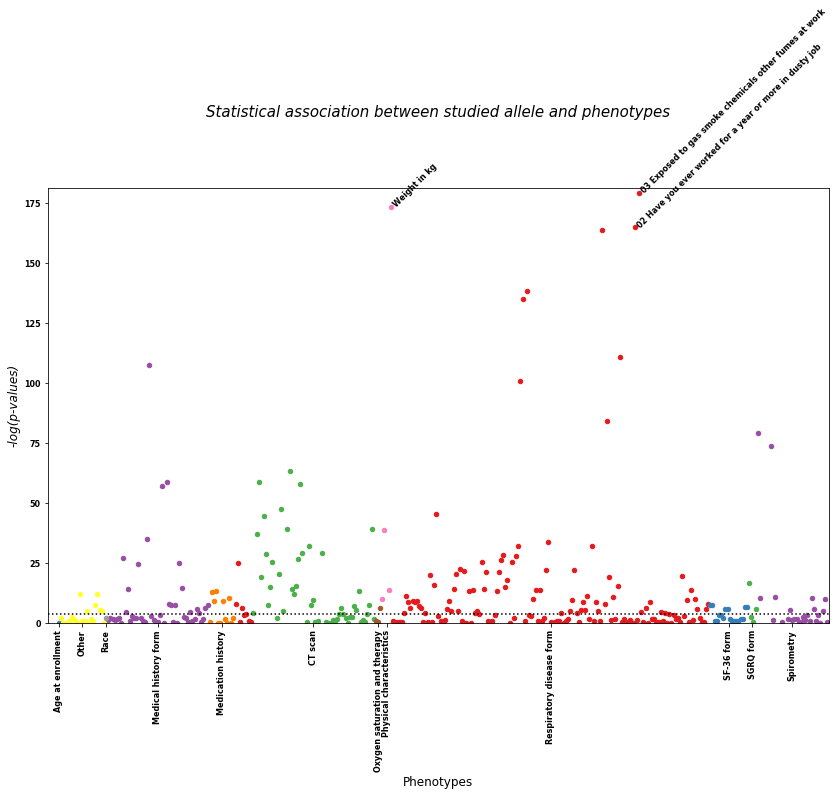

In [213]:
mask = variablesTable["pvalues"].isna()
df_results = variablesTable.loc[~mask,:].copy().replace([np.inf, -np.inf], np.nan)
df_results["ind"] = np.arange(1, len(df_results)+1)
df_grouped = df_results.groupby(('group'))

# print(df_grouped.head(10))

fig = plt.figure()
ax = fig.add_subplot(111)
colors = plt.get_cmap('Set1')
x_labels = []
x_labels_pos = []

y_lims = (0,
          df_results["p_adj"].max(skipna=True) + 2)
threshold_top_values = df_results["p_adj"].sort_values(ascending=False)[0:4][-1]

for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='p_adj',color=colors.colors[num % len(colors.colors)], ax=ax, s=20)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2)) # Set label in the middle
        for n, row in group.iterrows():
            if row["p_adj"] > threshold_top_values:
                ax.text(row['ind'] + 0.2, row["p_adj"] + 0.05, row["simplified_varName"], rotation=45, alpha=1, size=8, color="black")
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(df_results) +1])
ax.set_ylim(y_lims)
ax.set_ylabel('-log(p-values)', style="italic")
ax.set_xlabel('Phenotypes')
ax.axhline(y=-np.log10(adjusted_alpha), linestyle=":", color="black")
plt.xticks(fontsize = 8,rotation=90)
plt.yticks(fontsize = 8)
plt.title("Statistical association between studied allele and phenotypes", 
          loc="center",
          style="oblique", 
          fontsize = 15,
         y=1.15)
xticks = ax.xaxis.get_major_ticks()
xticks[0].set_visible(False)

plt.show()

### Features inquiry

### About the ability to have informations included in the dictionary useful to select variables for a PheWAS

One need some coarse decision criteria to include variables in a PheWAS, without looking at each different variables one by one. Hence, some examples of decision crtieria could be: 
* Categorical variables which compound at least a certain number individuals in each one of those categories. 
* Any variables with at least three different values 
* Outliers in the distribution of variables: like continuous variables with only two different values, categorical with more than XXXX variables

Plus, those criteria wouldn't be too specific, as those informations could be useful in a various range of different studies.

So something very handy could be a function that would be something like query.summary(), that would output, for each variable, number of categories and number of output in each one of those categories.